# sivtempfit generative model development

**Ruffin Evans**

2016-04-10

Last Update: 2016-05-05

This notebook develops the generative model that will eventually be used to fit the spectra data in this package.

I'll do this in two steps.

First, I'll write down the generative model. The end result of this section will be to produce a spectrum that "looks like" the spectra produced experimentally depending on the parameters.

Next, given this generative model, I will write down the likelihood function which expresses how well the data agrees with the model (literally, the likelihood that the data is drawn from the model.) The main part that is hard about this is that I need to make a statement about the uncertanties in the data.

## Standard Imports

In [1]:
# makes plots display inline in notebook interface:
%matplotlib inline 

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
import emcee
import pandas as pd
import seaborn as sns
import scipy.stats as stats # Use for KDE in the end
import scipy.optimize as opt # Use for minimizing KDE
import scipy as sp
sns.set_style("whitegrid")

## Generative Model

The model that I'll start with is fairly simple. It contains two peaks: one for the laser line, and one for the SiV itself.

Some preliminary fitting suggests that both peaks are very well fit by a Lorentzian and not by a Gaussian. Physically, it's not clear what the situation should be. For a single SiV, the spectrum should be Lorentzian, but we generally measure an ensemble of SiVs with enough of an inhomogeneous distribution that there could be a Gaussian component.

In the future, therefore, I may upgrade this model to fit a [Voigt profile](http://scipython.com/book/chapter-8-scipy/examples/the-voigt-profile/) to these lines instead. But this is possibly computationally more expensive (both in terms of evaluating the function and in terms of the added parameters) so let's just stick with the two-lorentzian model for now.

### A word about resolution

Vinny suggested that I include in my model some "blur" from the spectrometer itself. This effects the two peaks in the spectrum in two separate ways.

The laser line is intrinsically much narrower ($\lesssim 100 \mathrm{MHz}$) than the resolution of the spectrometer ($\sim10\mathrm{GHz}$). Hence, the laser line is only limited by the resolution of the spectrometer, and blurring this line would be accounting for this effect twice.

The SiV line is intrinsically much broader ($\sim2\mathrm{THz}$) than the resolution of the spectrometer, so the effect of the spectrometer resolution will be minimal.

Finally, if both lines are indeed lorentzians, then that means the transfer function of the spectrometer is a lorentzian. Since the siv line is lorentzian by assumption, and the convolution of two lorentzians is a lorentzian, fitting a single lorentzian is actually general in this case.

Motivated by these considerations, I will not introduce a specific blurring from the spectrometer for now.

### Construction of the model

The model here has two Lorentzian peaks plus a constant background. The peaks have arbitrary amplitude and width (although we have strong priors on the width on the narrower (laser) peak).

We'll parameterize the center positions of the peak with two variables: $C_2$ and $C_2-C_1$. This choice is motivated by the desire to use the laser peak with center $C_2$ as a calibration, so $C_1-C_2+\lambda_2$ is the actual center position of peak 1 independent of the wavelength calibration of the instrument since $\lambda_2$ is known exactly.

First, define a standard Lorentzian. This could be done by using scipy.stats.cauchy.pdf , but I'm not sure if that is efficient.

In [2]:
def lorentz(x, center, width):
    """
    A lorentzian function with peak position 'center' and FWHM 'width'.
    """
    return (1/np.pi)*(width/2)/((x-center)**2+(width/2)**2)

Now, we can define the model

In [3]:
def two_peak_model(x, amp1, amp2, center_offset, center2, width1, width2, background):
    return background + amp1*lorentz(x, center_offset + center2, width1) + amp2*lorentz(x, center2, width2)

For example, we expect the spectra to look something like this:

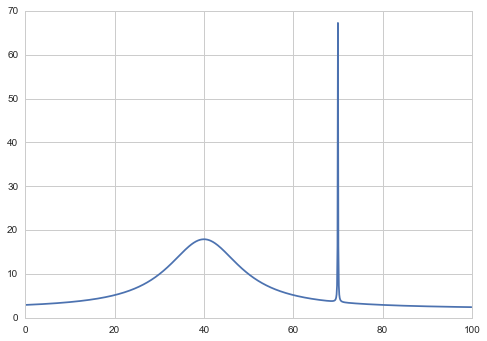

In [4]:
xrange = np.arange(0,100,0.1)
plt.plot(xrange, two_peak_model(xrange, 500, 10, -30, 70, 20, 0.1, 2))

## Likelihood

### Introduction

As noted above, this requires us to make statements about the noise in our system. We have characterized our system a bit and the noise seems to be primarily limited by shot noise. 

There are some subleties here, however. The shot noise is only on the photons that are actually detected, whereas there is also a readout noise on the detector of "three electrons" (according to the datasheet) per bin. Absent any other information, I assume this is gaussian noise. Moreover, the detector itself contributes a more or less fixed background (of around 1000 counts) on top of this noise. So, we'll include an additional term in the likelihood that includes this fixed CCD readout background plus associated noise.

The likelihood is then the product of two terms: one is a Gaussian likelihood for the CCD background, and one is a Poisson likelihood for the actual photon signal. In each of these two terms, we subtract the contribution to the signal from the other term before we calculate that contribution to the likelihood. In other words, for the CCD background, we take the signal, subtract what we think is coming from the light entering the instrument --- which is the two_peak_model --- and then consider Gaussian noise on that residual bit. For the poisson noise, we subtract the CCD offset from the signal before we fit the poisson noise.

I am not sure if this is the correct thing to do, because it means that if there is gaussian noise on the CCD, it still reduces the likelihood for the poisson contribution because we are subtracting only the background and not any noise. I will try to figure out if this is legit.

### Note on parameterization

In the future, we will test a model for the temperature dependence of $C_1$ which we expect to be approximately linear over a suitable range. Anticipating this, we will write $C_1 = (T-T_0)\times m+\lambda_0$ where $m = \frac{d\lambda}{dT}$ and $T_0$ and $\lambda_0$ are the offsets for the linear scaling. We can combine these two offsets into a single dummy variable $C_0$.

Note that this linear scaling is nonphysical: it is just an approximation that holds fairly well over a small temperature range. We'll have to change this formulation slightly to test higher order models for the temperature scaling.

Here, we will also switch to the (for now, redundant) parameterization in terms of $T$ and $m$, plus an offset $C_0$. For fitting a single spectrum, $T$ can be set to zero and the fit will be in terms of $C_0$ only.


### Formal construction of likelihood

(For this section, I found the following paper useful: http://epubs.siam.org/doi/abs/10.1137/15M1014395?journalCode=sjisbi)

For each data point $y_i$ we have the prediction of our model $z_i=m_i(\theta)$ plus two sources of error $f_i$ and $g_i$ corresponding to Poisson and Gaussian noise respectively.

$$y_i = m_i(\theta) + f_i + g_i$$

We assume that these two sources of error (photon shot noise and electron readout noise) are uncorrelated. Then we can write down the joint distribution:

$$e_i = f_i + g_i$$

which is just the convolution of the two noise sources. Once we have $e_i$, the formulation we have learned in class can be applied. (Alternatively, we can go through the integral formulation that Gregory does with these two sources of error -- there will be an extra integral involved and the convlution will arise organically.) Following this logic, the likelihood to detect $y_i$ photons is the convolution of the likelihood terms from the two error processes:

$$\mathcal{L}(y_i) \equiv p(y_i \mid M, \theta, I) = \sum_{n=0}^\infty\frac{\mu_i^n}{n!}e^{-\mu_i}\cdot \frac{1}{\sqrt{2\pi}\sigma} e^{-\frac{((y_i-n)-b)^2}{2\sigma^2}}$$

Let's unpack this. We have a (discrete) convolution of two terms, which intuitively expresses the idea that we are detecting $y_i$ photons but that this signal could be divided different ways between the two sources of noise.

The first term arises from considering the Poisson distribution with mean $\mu_i$. Here, $\mu_i$ is the value predicted from the model above and accounts only for the photons hitting the detector (which can include some background).

The second term arises from considering the Gaussian distribution with mean $b$ and standard deviation $\sigma$. This term has nothing to do with the above model (in that sense, the above model is incomplete or at least underparameterized) and arises from the CCD background noise which is Gaussian with some mean and standard deviation.

### Numerical interlude

To calculate the likelihood, we need to perform a convolution (which amounts to performing a sum) for each data point. This gives the likelihood of a single data point. Then we need to multiply together the likelihood of all of these data points and take the log.

We can do this in a `for` loop, but in python it's better if we can use numpy to do this in a fully vectorized way. How do we do that?

Well, we have three lists: the list of predictions for the model, the list of the actual data point values, and the photon numbers $n$ over which to perform the convolution. Two of these lists have the same dimensions and have corresponding values, but the photon number list is a different animal -- its values do not "match up" with the values in the other two lists. Rather, we want to do a sort of outer product where we perform the convolution for each data point in the data and model lists.

This requires telling `numpy` how to do the broadcasting. Here is a simple example.

In [5]:
ydata = np.arange(0,1.1,0.5)
conv_range = np.arange(0, 1.1, 0.25)
# Can do the outer product like this
new_data = (ydata**conv_range[:,np.newaxis])
print(ydata)
print(conv_range)
print(conv_range[:,np.newaxis])
print(new_data)
print(new_data.shape)
# Zero sums along columns, 1 sums along rows
# Here, doing a*b[:,np.newaxis] gives a table with dims (len(b), len(a)) that has [b_1*a, b_2*a, b_3*a]
# So summing along axis 0 is the correct thing to do if we want to do convolution and b is the set of things to convolve.
# Then we have a list of likelihoods, which we can np.product and then log
print(np.sum(new_data, 0))
# Seems like you need to do np.newaxis thing after each operation with the convolution variable
# But not for the y data variable; the axes match up and that can be broadcast.
print((ydata**conv_range[:,np.newaxis])/(conv_range[:,np.newaxis])*ydata)
# Element 2, 2 should be:
print(0.5**0.25/0.25*0.5)                                              

[ 0.   0.5  1. ]
[ 0.    0.25  0.5   0.75  1.  ]
[[ 0.  ]
 [ 0.25]
 [ 0.5 ]
 [ 0.75]
 [ 1.  ]]
[[ 1.          1.          1.        ]
 [ 0.          0.84089642  1.        ]
 [ 0.          0.70710678  1.        ]
 [ 0.          0.59460356  1.        ]
 [ 0.          0.5         1.        ]]
(5, 3)
[ 1.          3.64260675  5.        ]
[[        nan         inf         inf]
 [ 0.          1.68179283  4.        ]
 [ 0.          0.70710678  2.        ]
 [ 0.          0.39640237  1.33333333]
 [ 0.          0.25        1.        ]]
1.681792830507429


Now, when we want to do the convolution, each point should have the convolution done over a different range because it has a different number of photons. So what we really want is a different convolution list for each y value. Should just be $n=(y-b)\pm5\sigma$ (but at least zero) since Gaussian has essentially negligible support elsewhere. 

In [6]:
ydata = np.arange(0,1.1,0.5)
conv_range = np.arange(-5, 5)[:,np.newaxis]
# Each element in this list is a list of values over which to do the convolution.
conv_matrix = (ydata+conv_range)
print(conv_matrix)
# Now we can perform manipulations like so:
new_data = (ydata**conv_matrix)/(sp.misc.factorial(abs(conv_matrix)))
print(ydata)
print(new_data)
print(new_data.shape)
# To get the convolved data out, just do sum along first axis:
np.sum(new_data, 0)

[[-5.  -4.5 -4. ]
 [-4.  -3.5 -3. ]
 [-3.  -2.5 -2. ]
 [-2.  -1.5 -1. ]
 [-1.  -0.5  0. ]
 [ 0.   0.5  1. ]
 [ 1.   1.5  2. ]
 [ 2.   2.5  3. ]
 [ 3.   3.5  4. ]
 [ 4.   4.5  5. ]]
[ 0.   0.5  1. ]
[[             inf   4.32293011e-01   4.16666667e-02]
 [             inf   9.72659274e-01   1.66666667e-01]
 [             inf   1.70215373e+00   5.00000000e-01]
 [             inf   2.12769216e+00   1.00000000e+00]
 [             inf   1.59576912e+00   1.00000000e+00]
 [  1.00000000e+00   7.97884561e-01   1.00000000e+00]
 [  0.00000000e+00   2.65961520e-01   5.00000000e-01]
 [  0.00000000e+00   5.31923041e-02   1.66666667e-01]
 [  0.00000000e+00   7.59890058e-03   4.16666667e-02]
 [  0.00000000e+00   8.44322287e-04   8.33333333e-03]]
(10, 3)


array([        inf,  7.95604891,  4.425     ])

Finally, we need to be careful that we don't divide by zero, which will happen if we pass a negative number to the factorial function. To do this, replace negative numbers by NaN, and then set all NaNs to zero. Can do this with masking:

In [8]:
conv_matrix = (ydata+conv_range)
print(conv_matrix)
print(conv_matrix[conv_matrix<0])
conv_matrix[conv_matrix<0] = np.nan
print(conv_matrix)

[[-5.  -4.5 -4. ]
 [-4.  -3.5 -3. ]
 [-3.  -2.5 -2. ]
 [-2.  -1.5 -1. ]
 [-1.  -0.5  0. ]
 [ 0.   0.5  1. ]
 [ 1.   1.5  2. ]
 [ 2.   2.5  3. ]
 [ 3.   3.5  4. ]
 [ 4.   4.5  5. ]]
[-5.  -4.5 -4.  -4.  -3.5 -3.  -3.  -2.5 -2.  -2.  -1.5 -1.  -1.  -0.5]
[[ nan  nan  nan]
 [ nan  nan  nan]
 [ nan  nan  nan]
 [ nan  nan  nan]
 [ nan  nan  0. ]
 [ 0.   0.5  1. ]
 [ 1.   1.5  2. ]
 [ 2.   2.5  3. ]
 [ 3.   3.5  4. ]
 [ 4.   4.5  5. ]]


### Full specification of likelihood

We can now construct the likelihood function. I will simply reference the latest version from the package, because it is the most up-to-date and best documented.

In [10]:
import sivtempfit.model
import inspect

In [13]:
inspect.getsourcelines(sivtempfit.model.two_peak_log_likelihood)

(['def two_peak_log_likelihood(x, y, amp1, amp2, T, m, C0, center2,\n',
  '                            width1, width2, light_background,\n',
  '                            ccd_background, ccd_stdev,\n',
  '                            conv_range = -1, debug = False,\n',
  '                            test_norm = False, safe = False,\n',
  '                            gaussian_approx = False):\n',
  '    """\n',
  '    Returns the log-likelihood calculated for the two-peak + CCD noise model.\n',
  '    See also: two_peak_model\n',
  '    Parameters:\n',
  '    -----------\n',
  '    x : wavelength or x-axis value\n',
  '    y : corresponding observed data value\n',
  '    amp1 : amplitude of the broad SiV peak in the spectrum\n',
  '    amp2 : amplitude of the narrow calibration peak in the spectrum\n',
  '    T : The temperature of the sample\n',
  '    m : The linear scaling of the SiV peak position with temperature\n',
  '    C0 : The offset in the above linear scaling\n',
  '    cent